# **Analysing COVID19 Tweets!**
# Hello Data Scientist, Welcome to my notebook!
### <div align="left">  Today we shall perform EDA, Clustering using KMeans and Sentiment analysis on the Tweets (related to #Covid19) to answer the following questions:
Let us begin : 
</div>


1. Which countries tweeted the most? (based on Generalised Content)
> 1.1 which countries tweeted the most based on #Covid19 or tweets that are related to Corona/Covid19
2. Was the tweet based on Corona if so how frequent was the tweet based on 
> 2.1 User Accounts / User Names
>> 2.2 Country / Location 
>>> 2.3 Source / Device they tweeted from
3. How much did the Verified profile people tweeted in the year 2019 and 2020 based out of the country?
4. Monthly tweet trend of 2019 vs 2020
5. Who are the top 40 people/accounts that has most followers and their tweet count?
6. What are the most common words in the tweets?
7. Clustering the most commonly used tweet words into 5 groups
> 7.1 Group 1
>> 7.2 Group 2
>>> 7.3 Group 3
>>>> 7.4 Group 4
>>>>> 7.5 Group 5
8. What are the positive and negative sentiment words?
> Word-cloud of Positive and Negative twitter bird
9. What are the top 10 countries that tweeted with positive sentiments?
10. How is the data (countries, people, tweet content, month) distributed with sentiments?
> 10.1 In the Year 2019
>> 10.2 In the Year 2020

<div align="center"> 
    If you loved my notebook, please upvote to encourage me! 
</div> 

###### Pre-requirements

In [1]:
'''
numpy library
pandas library
matplot library
plotly library
wordcloud library
nltk library
PIL library
seaborn library
re library
scikit learn library
'''

'\nnumpy library\npandas library\nmatplot library\nplotly library\nwordcloud library\nnltk library\nPIL library\nseaborn library\nre library\nscikit learn library\n'

### Import Statements

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#stop=set(stopwords.words('english'))

from PIL import Image
import seaborn as sns
import re
from sklearn.datasets import make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import chardet

# tried building a nlp model for sentiments, but it was a time killer as i had prior exposure only on ANN and CNN 
#So made use of prebuild nlp model that predicts sentiments

'''
#from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences'''

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


'\n#from sklearn.model_selection import train_test_split\nfrom sklearn import preprocessing\nfrom sklearn import model_selection\nfrom sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer\nfrom collections import Counter\n\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense,Activation\nfrom tensorflow.keras.callbacks import EarlyStopping\nfrom tensorflow.keras.preprocessing.text import Tokenizer\nfrom tensorflow.keras.preprocessing.sequence import pad_sequences'

### Filepath of the dataset

In [3]:
filepath = r'../input/covid19-tweets/covid19_tweets.csv'
info_path = r'../input/covid-19-tweet-supporting-files/columns.txt'
#sentiment_filepath = r'C:/Users/riaz/learning/user_sentiment.csv'
df = pd.read_csv(filepath)
#sentiment = pd.read_csv(sentiment_filepath,encoding = 'latin',header=None,names=['target','id','time','query','usr','text'])
info = pd.read_csv(info_path,delimiter='->',names=['title','description'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


### Correlation of given datas with heatmap

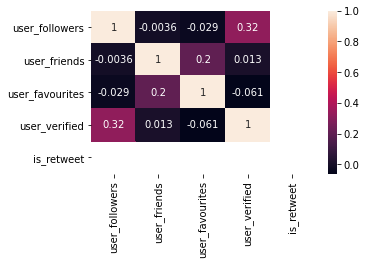

In [4]:
plt.figure(figsize=(5,3))
sns.heatmap(df.corr(),annot=True,linecolor='white',linewidths=0)

#### Plotting unique features in the dataset

In [5]:
def unique_features(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['uniques'] = uniques
    return unique_dataframe

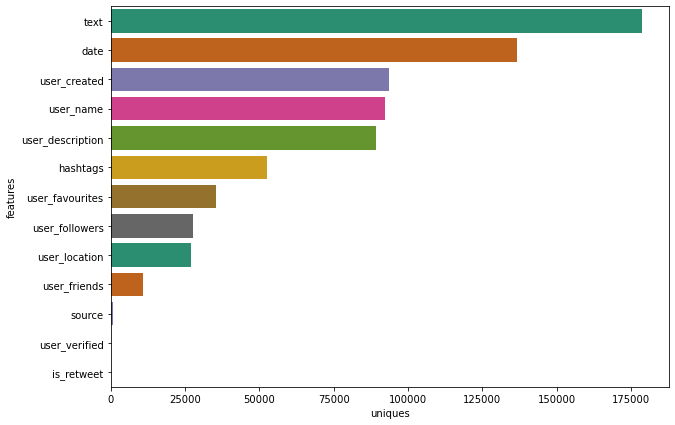

In [6]:
features = unique_features(df)
#print(features)

plt.figure(figsize=(10,7))
features = features.sort_values(by='uniques',ascending=False)
sns.barplot(x='uniques',y='features',data=features,palette='Dark2')

### CONVERTING TIME STAMPS

In [7]:
df['user_created'] = pd.to_datetime(df['user_created'])
df['only_date'] = pd.to_datetime(df['user_created']).dt.date
df['created_year'] = df['user_created'].apply(lambda date : date.year)
df['created_month'] = df['user_created'].apply(lambda date : date.month)
df['created_day'] = df['user_created'].apply(lambda date : date.day)

### Data cleaning

###### Checking for empty objects / nan 

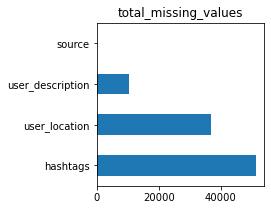

In [8]:
data = df.isnull().sum().sort_values(ascending=False)[:4]
plt.figure(figsize=(3,3))
data.plot(kind='barh',grid=False,sort_columns=True,title='total_missing_values')

###### Grouping / cleaning unknown dataset

In [9]:
df['user_location'].fillna('Unknown', inplace=True)
df['user_description'].fillna('Unknown', inplace=True)
df['source'].fillna('Unknown', inplace=True)
df['hashtags'].fillna('None', inplace=True)

###### Cleaning and Extracting  country name from "user_ locations"

In [10]:
#splitting a string into 2 words, where the first word corresponds to city name and second word to the country name
#this acts only if the given str has a ',' in it else it would return the same
df['country'] = df['user_location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)
df['city'] = df['user_location'].apply(lambda x: x.split(",")[0].strip() if ("," in x) else x)

#replacing the two digit US city names with USA except UK and EU
df['country'] = df['country'].apply(lambda x: 'USA' if (len(x.lower().strip())<3) and ((x!='uk')|(x!='eu')) else x)
#replacing lower case country names with standard ones
df['country'] = df['country'].apply(lambda x: 'USA' if x.lower().strip() in ("united states,Alabama, Alaska, American Samoa, Arizona, Arkansas, California, Colorado, Connecticut, Delaware, District of Columbia, Florida, Georgia, Guam, Hawaii, Idaho, Illinois, Indiana, Iowa, Kansas, Kentucky, Louisiana, Maine, Maryland, Massachusetts, Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, Nevada, New Hampshire, New Jersey, New Mexico, New York, North Carolina, North Dakota, Northern Mariana Islands, Ohio, Oklahoma, Oregon, Pennsylvania, Puerto Rico, Rhode Island, South Carolina, South Dakota, Tennessee, Texas, U.S. Virgin Islands, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming california, texas, usa,new york, us") else x)
df['country'] = df['country'].apply(lambda x: 'Canada' if x.lower().strip() in ("ontario,toronto,quebec,montreal,quebec city,vancouver") else x)
df['country'] = df['country'].apply(lambda x: 'UK' if x.lower().strip() in ("united kingdom,london, england,uk, britain,great britain") else x)
df['country'] = df['country'].apply(lambda x: 'India' if x.lower().strip() in ("india,mumbai,tamil nadu,chennai,karnataka,bengaluru,kerala,thiruvanandhipuram,kochi,patna,delhi,new delhi,uttar pradesh,andhra pradesh,telengana,vishakapatinam,hyderabad,himachal pradesh,goa,jammu,jammu and kashmir,ladhak") else x)
df['country'] = df['country'].apply(lambda x: 'N/A' if x.lower().strip() in ("worldwide, earth, global") else x)


#if country name is found in city name,
country_list = ['finland','netherlands','ireland','sweden','germany','denmark','switzerland','norway','france','spain','canada','bulgaria','belgium','estonia','uk','luxembourg','newzealand','austria','italy','australia','latvia','cyprus','singapore','japan','northmacedonia','southkorea','moldova','slovakia','romania','portugal','poland','czechrepublic','slovenia','costarica','chile','iceland','lithuania','georgia','hungary','usa','russia','greece','india','malaysia','armenia','southafrica']

def checker(x):
    #checking for city names in country list
    if x['city'].lower().strip() in country_list:
        #if city name is not same as country name but is in country list
        if x['city'].lower().strip() != x['country'].lower().strip():
            return x['city']
        else:
            return x['country']
    else:
        return x['country']

df['country'] = df[['city','country']].apply(checker,axis=1)

###### Hashtage cleaner fuction, which groups tweets that are specific to Covid 19 

In [11]:
corona_keys = ['covid19','covid_19','covid','pandemic','covid-19','corona','virus','coronavirus','coronavirusupdates']

def hashtag_grouper(a):
    b = a.replace("\'","").strip().strip("[").strip("]").lower()
    c = b.split(',')
    for item in c:
        if item in corona_keys:
            return 'Covid 19'
        else:
            return item

df['category'] = df['hashtags'].apply(hashtag_grouper)
df['covid'] = df['category'].apply(lambda x: True if x == 'Covid 19' else False)
coronadf = df[df['covid']>0]

##### creating a dataFrame that has count of  total number of tweets per country

In [12]:
#dataFrame of countries that tweeted general content
location_count = pd.DataFrame(df['country'].value_counts())
location_count.reset_index(inplace=True)
location_count = location_count.set_axis(['country', 'count'], axis=1)
location_count = location_count.sort_values(by='count',ascending=False)


#dataFrame of countries that tweeted about covid 19
location_count2 = pd.DataFrame(coronadf['country'].value_counts())
location_count2.reset_index(inplace=True)
location_count2 = location_count2.set_axis(['country', 'cv_count'], axis=1)
location_count2 = location_count2.sort_values(by='cv_count',ascending=False)

## 1. Countries that tweeted the most on generalised content

In [13]:
count_graph = px.bar(x='country',y='count',data_frame=location_count[1:16],color='country',
                    labels={'x':'Countries','y':'Counts'},title='Generalised Tweets')
count_graph.show()

## 1.1 Now, we shall see countries that specifically tweeted the most about Covid 19 and their tweet counts respectively

In [14]:
count_graph2 = px.bar(x=location_count2['country'][1:16],y=location_count2['cv_count'][1:16],
                      color=location_count2['country'][1:16],labels={'x':'Countries','y':'Counts'},
                      title='Tweets based on corona/Covid 19')
count_graph2.show()

### 2. EDA on tweets from the year 2019 (i.e. 2019 + 2020) based on

In [15]:
def graph(data, feature, title, pallete):
    f, ax = plt.subplots(1,1, figsize=(18,6))
    total = float(len(df))
    if feature == 'user_location' or 'country' or 'city' or 'user_names':
        g = sns.countplot(data[feature],hue= data['covid'],order = data[feature].value_counts().index[1:11], palette=pallete)  
    elif feature == 'source':
        g = sns.countplot(data[feature],hue= data['covid'],order = data[feature].value_counts().index[:16], palette=pallete)
    else:
        g = sns.countplot(data[feature],hue= data['covid'], order = data[feature].value_counts().index[0:11], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Counts & Percentage representation of {} that were actually tweeting about Corona'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

### 2.1 This plot symbolizes how frequent did the top user tweeted and whether the content was related to Covid19

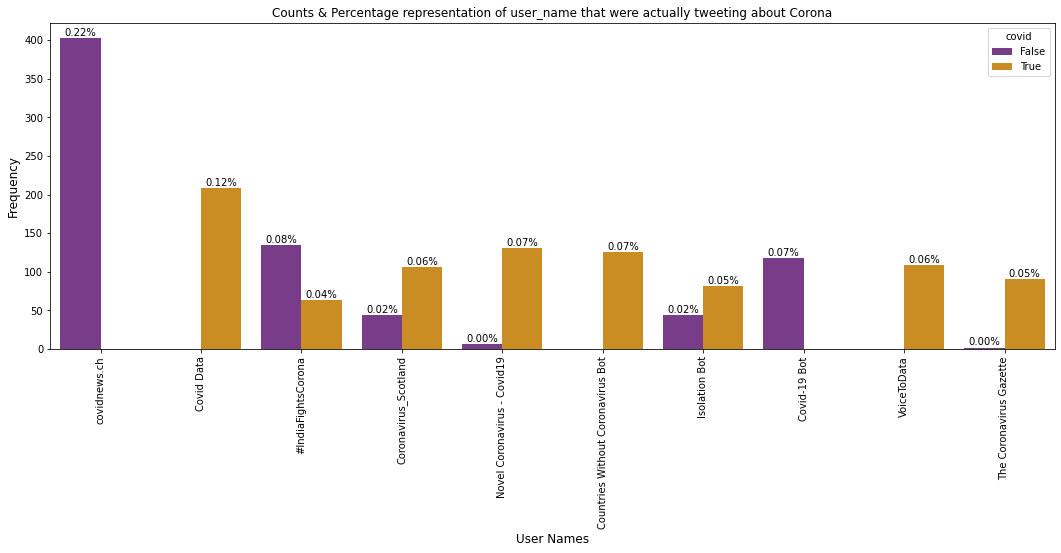

In [16]:
graph(df[df.created_year > 2019 ], 'user_name', 'User Names','CMRmap')

### 2.2 This plot symbolizes Where did the most tweets come from and whether the content was related to Covid19

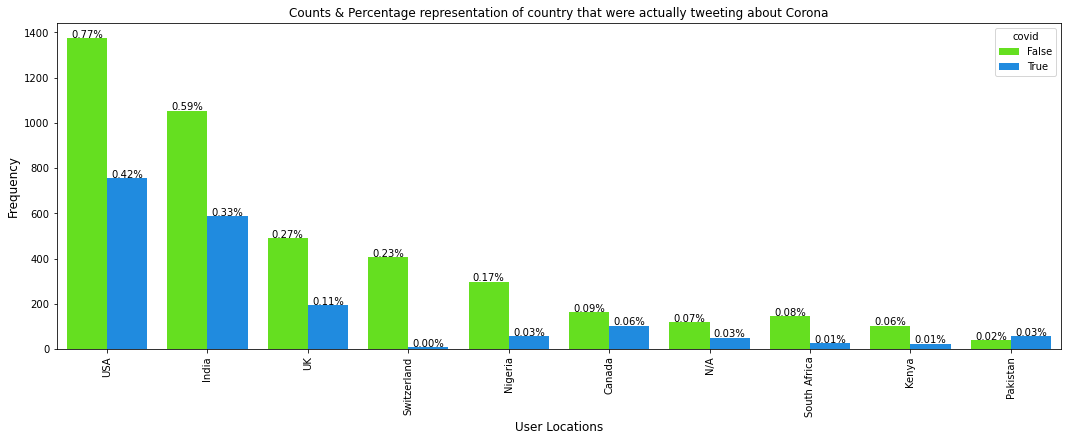

In [17]:
graph(df[df.created_year > 2019 ], 'country', 'User Locations', 'gist_rainbow')

### 2.3 This plot symbolizes from which devices did the tweets originated and whether the content was related to Covid19

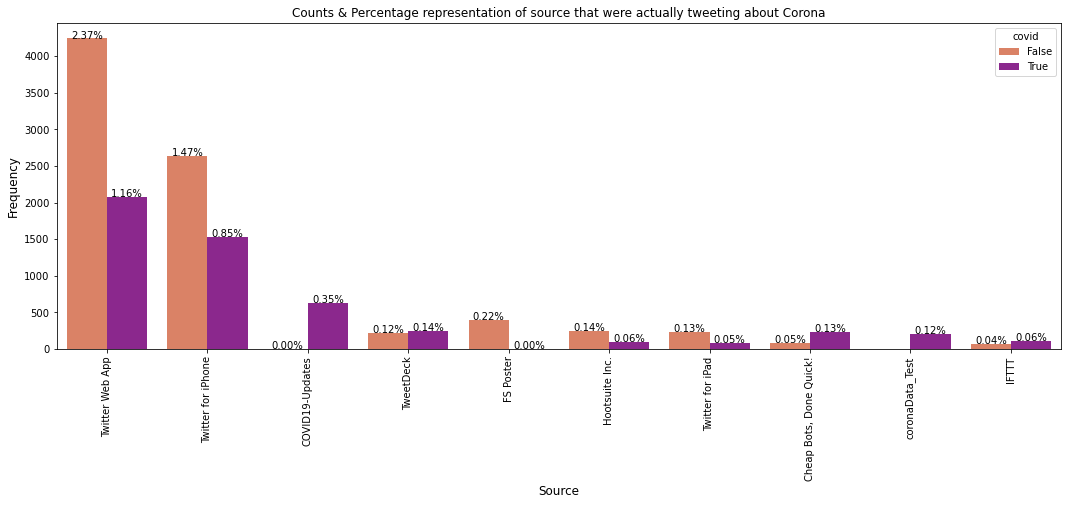

In [18]:
graph(df[df.created_year > 2019 ], 'source','Source', 'plasma_r')

### 3. This EDA show us how did the "verified_Profile" users reacted from the top 5 countries in the year 2019 and 2020

In [19]:
verified_corona = df[ (df.user_verified == True) & (df.covid == True) & (df.country == ('USA')) | 
             (df.country == 'India') | (df.country == 'Australia') | (df.country =='UK') | (df.country =='Canada') ]  

verified_corona_20 = verified_corona[verified_corona.created_year == 2020]
verified_corona = verified_corona[verified_corona.created_year == 2019]

Number of tweets from top 5 countries


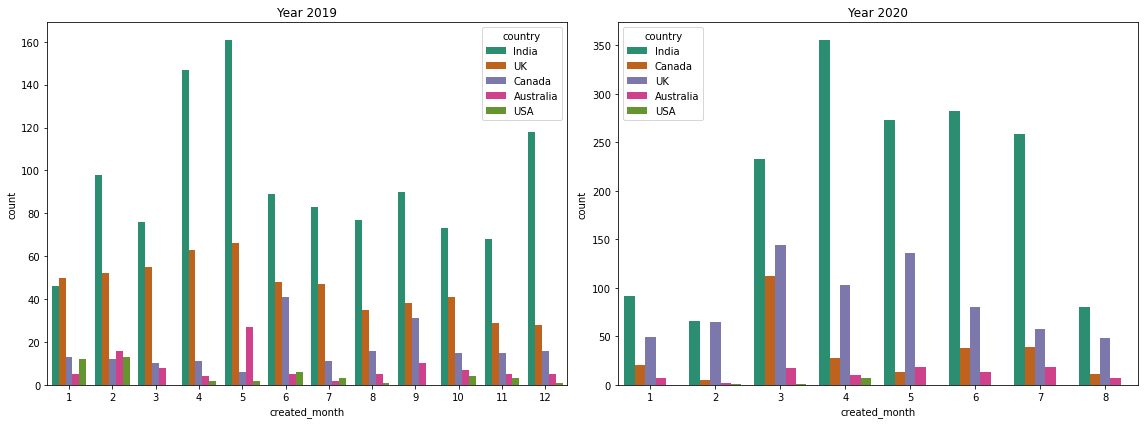

In [20]:
print('Number of tweets from top 5 countries')
f, axes = plt.subplots(1, 2,figsize=(16,6))
axes[0].set_title("Year 2019")
axes[1].set_title("Year 2020")
order_type = sorted(verified_corona['created_month'].unique())
sns.countplot(x=verified_corona.created_month, hue=verified_corona.country,palette="Dark2",order=order_type,ax=axes[0])
order_type = sorted(verified_corona_20['created_month'].unique())
sns.countplot(x=verified_corona_20.created_month, hue=verified_corona_20.country,palette="Dark2",order=order_type,ax=axes[1])

f.tight_layout()
plt.show()
#'Number of verified profile tweets in the year 2019 vs 2020'

### 4. Finding a pattern/Spike in tweets

##### From this **Line Chart**  we could see quite a spike in number of tweets(February,2020 to March,2020), that is when the WHO declared Global Pandemic and many nations started security measurments such as Lockdowns

In [21]:
tweet_from_2019 = df[df['created_year'] == 2019]
tweet_from_2020 = df[df['created_year'] == 2020]
tweets_month_19 =  tweet_from_2019['created_month'].value_counts().to_frame().reset_index().rename(columns={'index':'month','created_month':'count'})   
tweets_month_20 =  tweet_from_2020['created_month'].value_counts().to_frame().reset_index().rename(columns={'index':'month','created_month':'count'})   
tweets_month_19 = tweets_month_19.sort_values('month',ascending=True)
tweets_month_20 = tweets_month_20.sort_values('month',ascending=True)

fig=go.Figure()
fig.add_trace(go.Scatter(x=tweets_month_19['month'], y=tweets_month_19['count'],
                         mode='markers+lines',marker_color='firebrick',
                         name='Year 2019',line = dict(color='grey', width=4, dash='dot')))

#fig.update_layout(title_text='Tweets per Month and Date in the year 2019 and 2020 ',template="plotly", title_x=0.5)
fig.add_trace(go.Scatter(x=tweets_month_20['month'], y=tweets_month_20['count'],
                         mode='markers+lines',marker_color='darkred',name='Year 2020',
                        line=dict(color='orange', width=4,dash='longdashdot')))
fig.show()

### 5. Most popular user with thier tweet count and followers

In [22]:
ds = df['user_name'].value_counts().reset_index()
ds.columns = ['user_name', 'tweets_count']
ds = ds.sort_values(['tweets_count'])
df = pd.merge(df, ds, on='user_name')

data = df.sort_values('user_followers', ascending=False)
data = data.drop_duplicates(subset='user_name', keep="first")
data = data[['user_name', 'user_followers', 'tweets_count']]
data = data.sort_values('user_followers')
fig = px.bar(data.tail(40), x="user_followers", y="user_name",color='tweets_count',orientation='h', 
             title='Top 40 users by number of followers', width=1000, height=1000,template="plotly_dark")
fig.show()

###### Preprocession text from tweeted content

In [23]:
def remove_tag(string):
    text=re.sub('<.*?>','',string)
    return text
def remove_mention(text):
    line=re.sub(r'@\w+','',text)
    return line
def remove_hash(text):
    line=re.sub(r'#\w+','',text)
    return line

def remove_newline(string):
    text=re.sub('\n','',string)
    return text
def remove_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def remove_number(text):
    line=re.sub(r'[0-9]+','',text)
    return line
def remove_punct(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    #string="".join(line)
    return line
def text_strip(string):
    line=re.sub('\s{2,}', ' ', string.strip())
    return line
def remove_thi_amp_ha_words(string):
    line=re.sub(r'\bamp\b|\bthi\b|\bha\b',' ',string)
    return line

In [24]:
df['clean_tweet'] =  df['text'].str.lower()
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:remove_tag(str(x)))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:remove_mention(str(x)))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:remove_hash(str(x)))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:remove_newline(x))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:remove_url(x))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:remove_number(x))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:remove_punct(x))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:remove_thi_amp_ha_words(x))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:text_strip(x))

df['text_length']=df['clean_tweet'].str.split().map(lambda x: len(x))

### Word clouds

In [25]:
def build_wordcloud(var, title):
    wordcloud = WordCloud(background_color='black',colormap="bwr", 
                          stopwords=set(STOPWORDS),max_words=80, min_font_size= 8,
                          max_font_size=40, random_state=666).generate(str(var))

    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud,interpolation='bilinear')
    plt.show()

### 6. Creating a word cloud for the most popular words used

###### As predicted a  huge  propotion of words are about Covid!

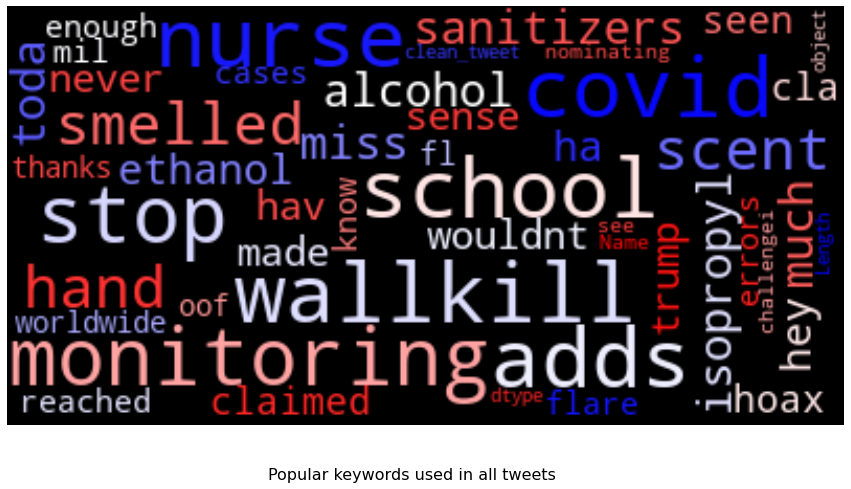

In [26]:
build_wordcloud(df['clean_tweet'], 'Popular keywords used in all tweets')

### 7. Clustering the most commonly used word using KMeans
 Cheers! 🥂 learnt from ( https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html )

In [27]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df['clean_tweet'].values)
features = vec.transform(df['clean_tweet'].values)

#taking an arbitary value say 5, to get 5 cluster values
kmeans = KMeans(n_clusters = 5,init ='k-means++', max_iter=300, random_state=0,verbose=1)
y_kmeans =  kmeans.fit_predict(features)
df['Cluster']  = y_kmeans
#df

Initialization complete
Iteration 0, inertia 347797.14477342984
Iteration 1, inertia 176017.54278912584
Iteration 2, inertia 175349.020532573
Iteration 3, inertia 175196.42316333152
Iteration 4, inertia 175115.0781273452
Iteration 5, inertia 175069.34758729115
Iteration 6, inertia 175045.39869892862
Iteration 7, inertia 175026.7785721912
Iteration 8, inertia 175010.06427484186
Iteration 9, inertia 174996.40412137794
Iteration 10, inertia 174986.1929915607
Iteration 11, inertia 174973.70274991152
Iteration 12, inertia 174959.3394514658
Iteration 13, inertia 174957.24488063212
Iteration 14, inertia 174956.6356520155
Iteration 15, inertia 174955.5889919179
Iteration 16, inertia 174954.28372280585
Iteration 17, inertia 174952.64210849535
Iteration 18, inertia 174950.1226591823
Iteration 19, inertia 174947.75459665252
Iteration 20, inertia 174945.74483498393
Iteration 21, inertia 174944.2276798294
Iteration 22, inertia 174943.0748764556
Iteration 23, inertia 174942.36880229186
Iteration 24,

In [28]:
#df[df['Cluster'] == 0].head(20)['text'].tolist()
#df[df['Cluster'] == 1].head(20)['text'].tolist()

##### 7.1 Word-cloud of Cluster 1

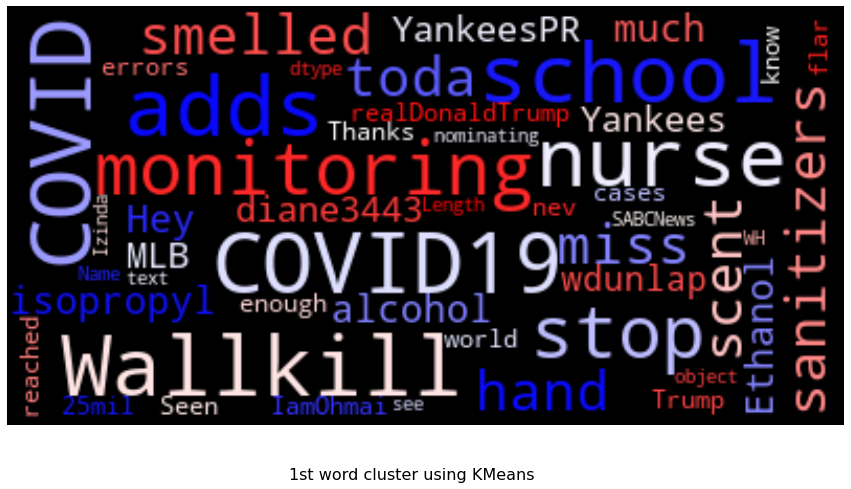

In [29]:
build_wordcloud(df[df['Cluster'] == 0]['text'], '1st word cluster using KMeans')

##### 7.2 Word-cloud of Cluster 2

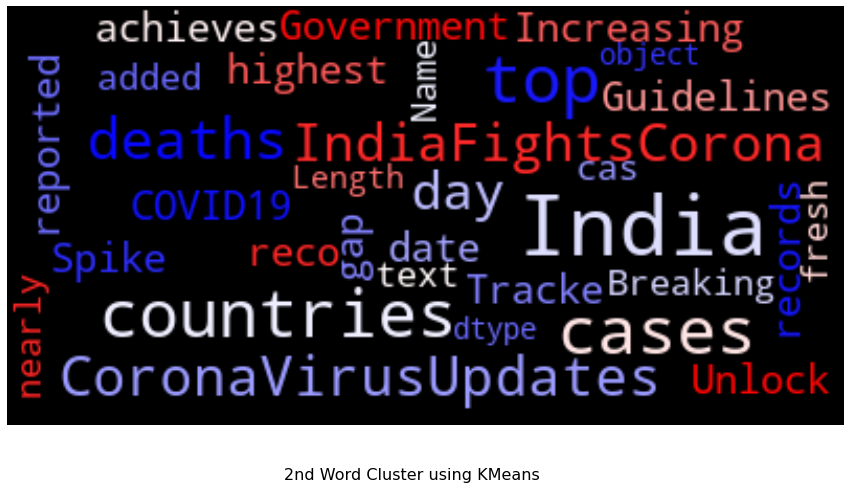

In [30]:
build_wordcloud(df[df['Cluster'] == 1]['text'], '2nd Word Cluster using KMeans')

##### 7.3 Word-cloud of Cluster 3

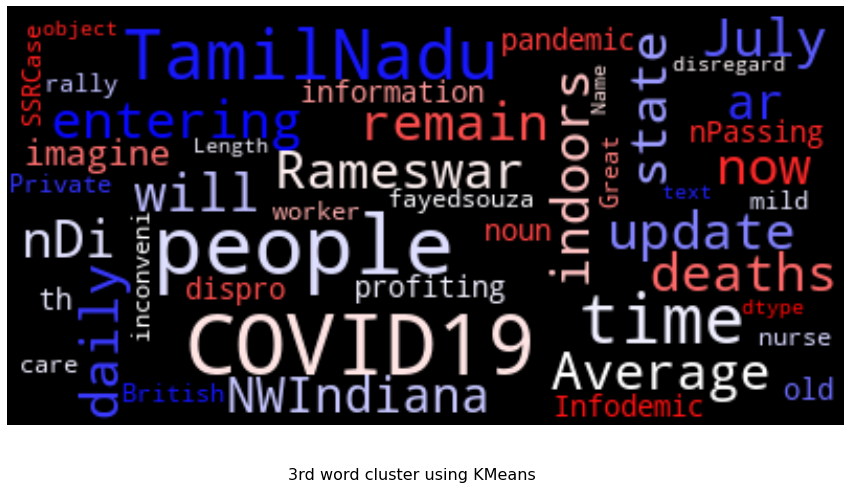

In [31]:
build_wordcloud(df[df['Cluster'] == 2]['text'], '3rd word cluster using KMeans')

##### 7.4 Word-cloud of Cluster 4

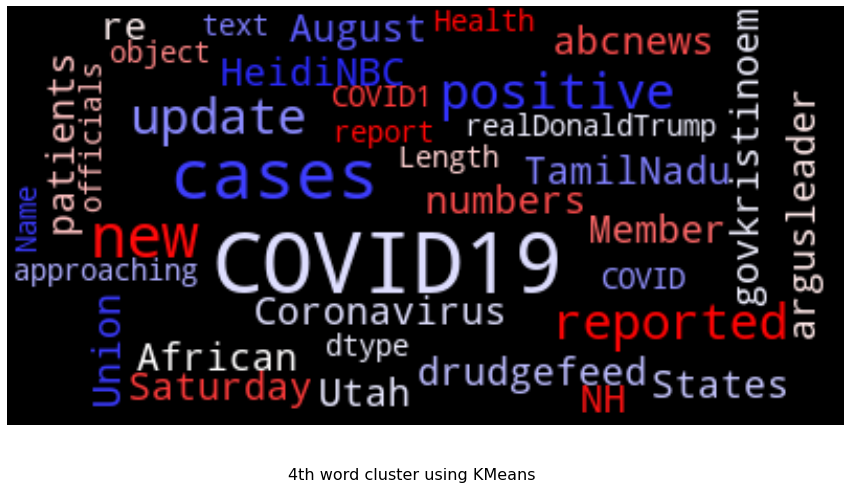

In [32]:
build_wordcloud(df[df['Cluster'] == 3]['text'], '4th word cluster using KMeans')

##### 7.5 Word-cloud of Cluster 5

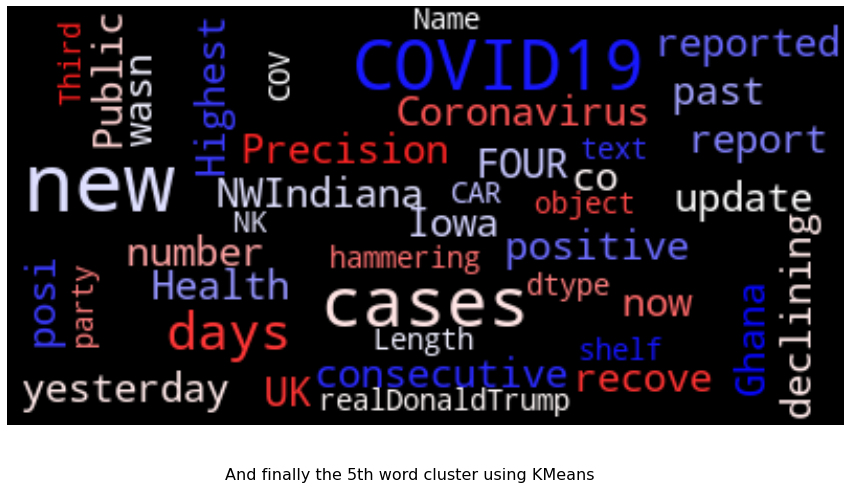

In [33]:
build_wordcloud(df[df['Cluster'] == 4]['text'], 'And finally the 5th word cluster using KMeans ')

### 8. Sentiment Analysis

###### Here we shall use sentiments of  two types i.e. Postivie Sentiments and  Negative Sentiments and extracting sentiments from a pretrained model

In [34]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_score(text):
    dict_res = sid.polarity_scores(text)
    return dict_res["compound"]

df["Score"] = df["clean_tweet"].apply(lambda x: get_score(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
df["Score"].describe()

count    179108.000000
mean          0.051751
std           0.391347
min          -0.973800
25%          -0.102700
50%           0.000000
75%           0.361200
max           0.969800
Name: Score, dtype: float64

In [36]:
pred_df=pd.DataFrame({'text':df['clean_tweet'],'pred_sentiment':df['Score'],'country':df['country'],'text_length':df['text_length']})
pred_df['pred_sentiment']=np.where(pred_df['pred_sentiment']>0.5,1,0)
pred_df[['text','pred_sentiment']].head(4)

,text,pred_sentiment
0,if i smelled the scent of hand sanitizers toda...,0
1,i miss isopropyl alcohol so much ethanol in ha...,1
2,hey and wouldnt it have made more sense to hav...,0
3,trump never once claimed was a hoax we all cla...,0


Text(0.5, 1.0, 'Positive Sentiment Bird')

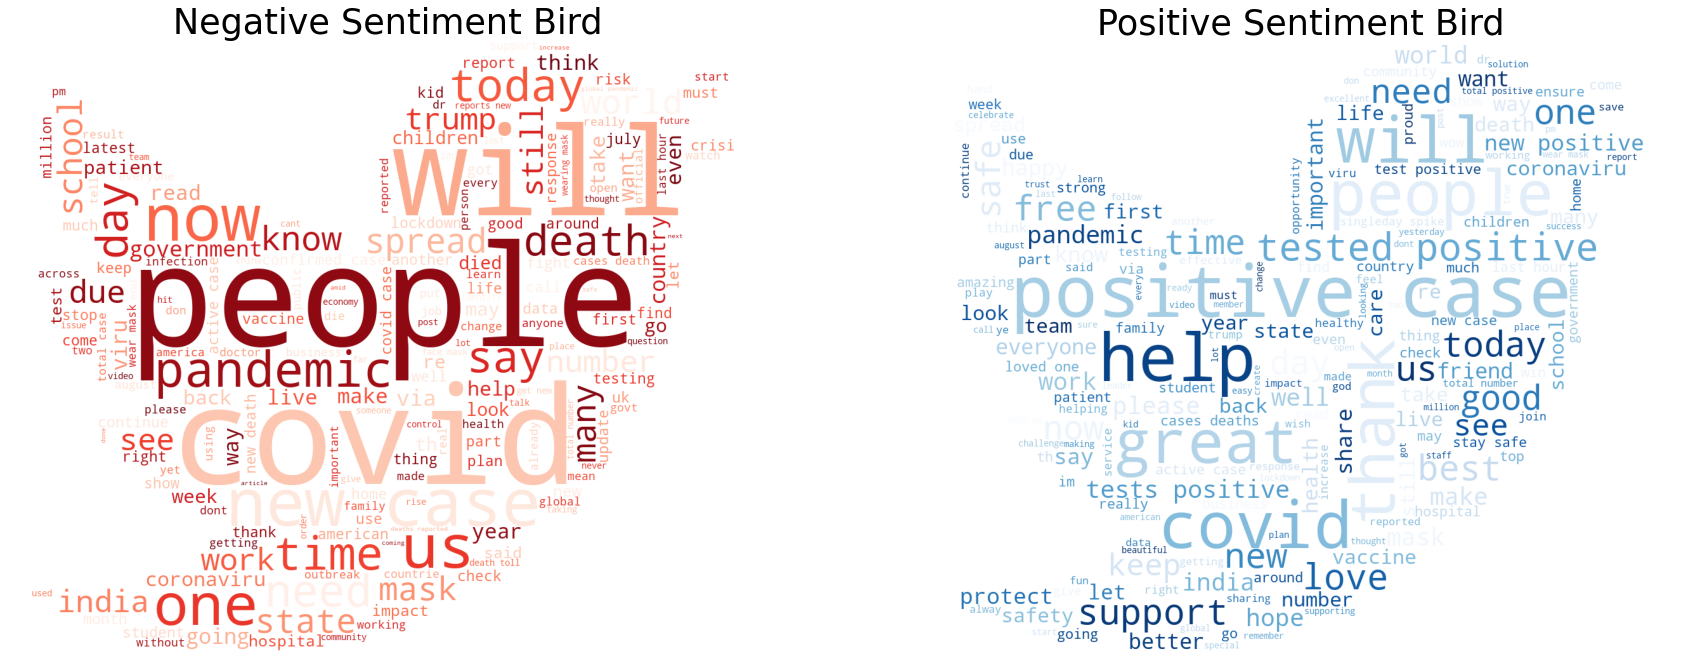

In [37]:
bird = np.array(Image.open('../input/covid-19-tweet-supporting-files/twitter_logo.jpg'))
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud2 = WordCloud( background_color='white',mask= bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(pred_df[pred_df['pred_sentiment']==0]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment Bird',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask= bird,colormap="Blues",
                        width=600,
                        height=400).generate(" ".join(pred_df[pred_df['pred_sentiment']==1]['text']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive Sentiment Bird',fontsize=35)

### 9. Top 10 countries that had positive sentiment of tweets

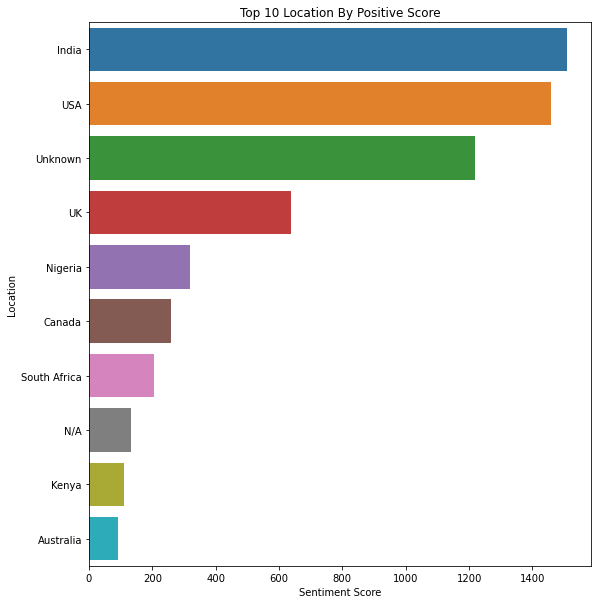

In [38]:
sentiment_countries = pd.DataFrame()
sentiment_countries["Score"] = df["Score"]
sentiment_countries["country"] = df["country"]

sentiment_countries = sentiment_countries.sort_values(by = "Score",ascending=False)
sentiment_countries = sentiment_countries.groupby("country").sum().sort_values(by = "Score",ascending=False)[:10]

plt.figure(figsize=(9,10))
sns.barplot(list(sentiment_countries.values.flatten()),sentiment_countries.index,)
plt.title("Top 10 Location By Positive Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Location")
plt.show()

### 10. Data distribution

#### 10.1 Overview of User Sentiments among the top three countries that tweeted during 2019

In [39]:
df_clean = df.drop(['user_description','user_location',	'user_created','text','is_retweet','date', 'hashtags' ],axis=1)
df_clean_19 = df_clean[(df_clean.created_year == 2019)]
top_3 = df_clean_19[(df_clean_19.country == 'USA') | (df_clean_19.country == 'India') | (df_clean_19.country == 'UK')]

In [40]:
fig = px.parallel_categories(top_3, dimensions=['country', 'user_verified','covid', 'created_month'],
                color="Score", color_continuous_scale=px.colors.sequential.Inferno,
                labels={'sex':'Payer sex', 'smoker':'Smokers at the table', 'day':'Day of week'})
fig.show()

##### 10.2 Overview of User Sentiments among the top three countries that tweeted during 2010

In [41]:
#df_clean = df.drop(['user_description','user_location',	'user_created','text','is_retweet','date', 'hashtags' ],axis=1)
df_clean_20 = df_clean[(df_clean.created_year == 2020)]
top_3_20 = df_clean_20[(df_clean_20.country == 'USA') | (df_clean_20.country == 'India') | (df_clean_20.country == 'UK')]

In [42]:
fig = px.parallel_categories(top_3_20, dimensions=['country', 'user_verified','covid', 'created_month'],
                color="Score", color_continuous_scale=px.colors.sequential.Inferno,
                labels={'sex':'Payer sex', 'smoker':'Smokers at the table', 'day':'Day of week'})
fig.show()


### <div align="center">   With endless possibilites of representation and uncertainity, I hereby end my assessment with good hope!

<div align="center"> Thanks and Regards,
<div align="center"> Mohamed Riaz | mohamed.riaz1307@gmail.com 
